In [97]:
import pandas as pd
#Load all the necessary datasets
df_ga=pd.read_csv('GA_final.csv')
df_ga.drop(columns=['Unnamed: 0', 'week_number'], inplace=True)
df_linkedin=pd.read_csv('df_final_linkedin.csv')
df_linkedin.drop(columns=['Unnamed: 0'], inplace=True)
df_dv360=pd.read_csv('dv360_final.csv')
df_dv360.drop(columns=['Unnamed: 0', 'week_number'], inplace=True)

In [98]:
import pandas as pd
from prophet import Prophet
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

11:30:27 - cmdstanpy - INFO - Chain [1] start processing
11:30:27 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.21391,7.52799,8.94251
3266,2017-01-16,8.53894,7.80541,9.29725
3267,2017-01-17,8.32637,7.55667,9.07749
3268,2017-01-18,8.15903,7.38482,8.91621
3269,2017-01-19,8.17099,7.47709,8.89550


conda create -n myenv python=3.9 pip
conda activate myenv
conda install numpy pandas plotly
pip install prophet
vim $HOME/miniconda3/envs/myenv/lib/python3.9/site-packages/holidays/registry.py

## Building the model

In [99]:
import seaborn as sns

In [100]:
import matplotlib.pyplot as plt

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import pandas as pd
import numpy as np
import math
import sys
import os


pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
import seaborn as sns

from plotnine import *


from IPython.core.debugger import set_trace

In [103]:
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [104]:
import numpy as np

In [105]:
from sklearn.model_selection import TimeSeriesSplit


In [106]:
import cmdstanpy

In [107]:
from functools import partial
import optuna as opt

In [108]:
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

## PROPHET 

What is Prophet?

Prophet is a forecasting tool developed by Facebook's Core Data Science team. It is designed to make time series forecasting accessible to non-experts, enabling analysts and data scientists to easily generate accurate forecasts without requiring advanced statistical knowledge.

Time Series Forecasting: Prophet is specifically built for time series forecasting, which involves predicting future values based on past patterns in the data.

Automatic Seasonality Detection: Prophet automatically detects and handles various types of seasonality in the data, such as yearly, weekly, and daily patterns.

Holiday Effects: It allows you to incorporate holiday effects or special events into the forecasting model, which can significantly impact time series data.

How we are going to use it:

We are not going to use Prophet's prediction per-say. What we are going to do is use the components (seasonailty, holiday, events) which have been generated and used by Prophet to make its predicitons. Once we have analyzed these components, we will ask prophet to predict the seasonality/events/holidays values for each row of our dataset (so basically we are going to include the parameters in the dataset)

In [109]:
# List of DataFrames to join
dataframes_list = [df_ga, df_linkedin, df_dv360]  # Replace df1, df2, df3 with your DataFrames

# Define the common date column on which you want to join
date_column = 'week_end'  

# Perform the outer join on multiple datasets
result_df = dataframes_list[0]  # Initialize the result DataFrame with the first DataFrame

# Loop through the rest of the DataFrames in the list and perform outer join one by one
for df in dataframes_list[1:]:
    result_df = pd.merge(result_df, df, on=date_column, how='outer')

# Fill missing values with 0
result_df.fillna(0, inplace=True)

# The result_df will contain the join of all the DataFrames with missing values filled as 0
result_df

#Create the final target variable, as the sum of individual clicks of the dataset
result_df['leads']=result_df['leads_linkedin']+result_df['leads_dv360']+result_df['leads_organic']

#Keep only the interesting columns, put the dat column in the right format, sort the dataset acording to dates
data_pr=result_df[['week_end', 'leads', 'leads_organic', 'spend_linkedin', 'spend_dv360']]
data_pr['week_end'] = data_pr['week_end'].astype('datetime64[ns]')
data_pr= data_pr.sort_values(by='week_end')
data_pr.reset_index(inplace=True)
data_pr.drop(columns=['index'], inplace=True)
data_pr


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,week_end,leads,leads_organic,spend_linkedin,spend_dv360
0,2020-01-05,0.00000,0.00000,0.00000,0.00000
1,2020-01-12,0.00000,0.00000,0.00000,0.00000
2,2020-01-19,0.00000,0.00000,0.00000,0.00000
3,2020-01-26,0.00000,0.00000,0.00000,0.00000
4,2020-02-02,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...
183,2023-07-09,165.00000,165.00000,0.00000,0.00000
184,2023-07-16,241.00000,241.00000,0.00000,0.00000
185,2023-07-23,172.00000,172.00000,0.00000,0.00000
186,2023-07-30,151.00000,151.00000,0.00000,0.00000


In [110]:
#Rename the week_end and clicks columns to ds and y. This is because that is the name these columns must make for them to be processed by the prophet algorithm
prophet_data= data_pr.rename(columns={'week_end': 'ds', 'leads':'y'})

In [111]:
prophet_data

,ds,y,leads_organic,spend_linkedin,spend_dv360
0,2020-01-05,0.00000,0.00000,0.00000,0.00000
1,2020-01-12,0.00000,0.00000,0.00000,0.00000
2,2020-01-19,0.00000,0.00000,0.00000,0.00000
3,2020-01-26,0.00000,0.00000,0.00000,0.00000
4,2020-02-02,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...
183,2023-07-09,165.00000,165.00000,0.00000,0.00000
184,2023-07-16,241.00000,241.00000,0.00000,0.00000
185,2023-07-23,172.00000,172.00000,0.00000,0.00000
186,2023-07-30,151.00000,151.00000,0.00000,0.00000


In [112]:
prophet_data['spend_dv360'].value_counts()

0.00000        113
13556.48662      1
43777.93913      1
25692.05365      1
24210.56262      1
              ... 
19971.68294      1
22817.77260      1
18196.82403      1
52391.49270      1
12916.38808      1
Name: spend_dv360, Length: 76, dtype: int64

In [113]:
#Setting the desired Prophet hyperparameters. By adding the weekly seasonality parameter, we will get access to seasonalities on a weekly basis 
#By adding holidays to the prophet algorithm, 
prophet = Prophet(weekly_seasonality=True)
prophet.add_country_holidays(country_name='AE')
prophet.add_regressor(name = "spend_dv360")
prophet.add_regressor(name = "spend_linkedin")
prophet.add_regressor(name = "leads_organic")


In [114]:
#Fitting the Prophet algorithm to our dataset
prophet.fit(prophet_data[["ds", "y", "spend_dv360", "spend_linkedin", "leads_organic"]])

#making the model predict the values of clicks based on the algorithm that has been trained and fitted to the historical clicks values
prophet_predict = prophet.predict(prophet_data[["ds", "y", "spend_dv360", "spend_linkedin", "leads_organic"]])

11:30:29 - cmdstanpy - INFO - Chain [1] start processing
11:30:29 - cmdstanpy - INFO - Chain [1] done processing


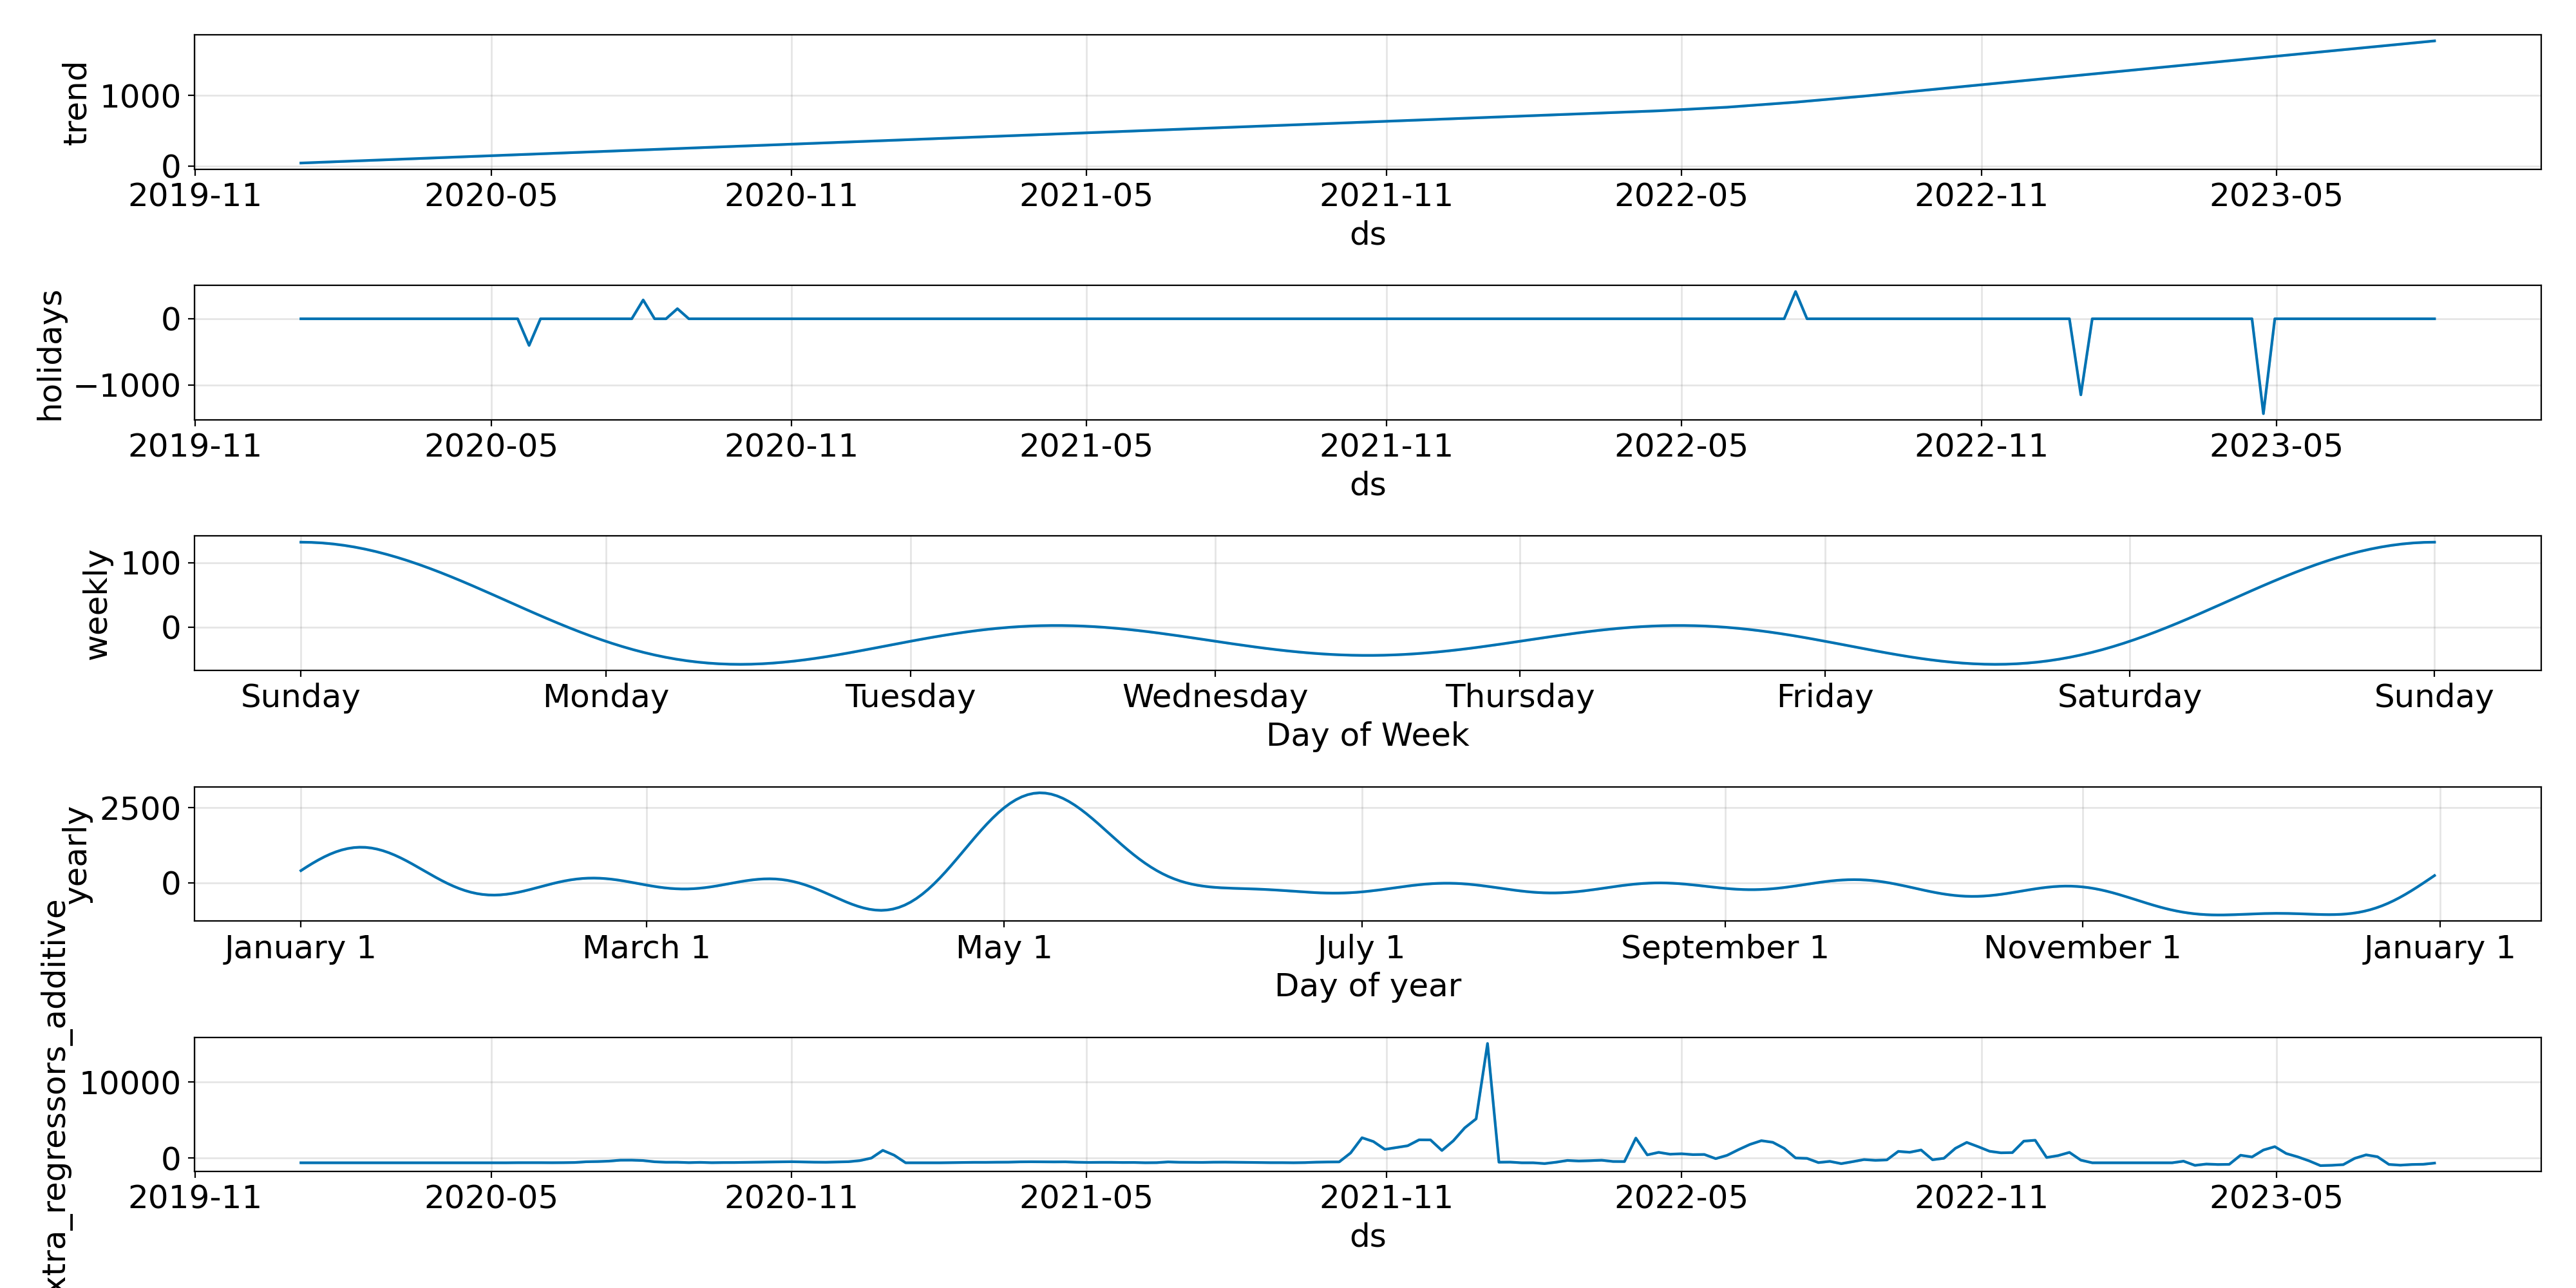

In [115]:
#Plotting all the parameter values used by the prophet algorithm to carry out its predictions. For each parameter estimated by the algoritm,
#the graph plots the additive effect of each parameter as a function of time. 

plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [116]:
import numpy as np
#Use of the trained algorithm to predict the values of prophet_data. By doing this, we can extract the predicted values of trend, seasonailty
# and holidays for each row of our dataset. Once the resulting dataset (prophet_predict) columns is done, we append these columns to our ogiginal dataset!
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)

#Creation of final data, which is a copy of our original dataset
final_data = data_pr.copy()

#append all the columns of the predicted dataset
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]
final_data["holiday"] = prophet_predict["holidays"]
final_data["events"] = (events_numeric - np.min(events_numeric)).values

In [117]:
# Just for you personal information: this dataset is the result of the application of prophet's forecasts on our original data
prophet_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Arafat Day,Arafat Day_lower,Arafat Day_upper,Arafat Day* (*estimated),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-05,43.97115,-1868.10127,2297.23558,43.97115,43.97115,0.00000,0.00000,0.00000,0.00000,...,132.00009,132.00009,132.00009,790.41948,790.41948,790.41948,0.00000,0.00000,0.00000,330.48640
1,2020-01-12,50.18081,-1283.90200,2604.49781,50.18081,50.18081,0.00000,0.00000,0.00000,0.00000,...,132.00009,132.00009,132.00009,1186.40599,1186.40599,1186.40599,0.00000,0.00000,0.00000,732.68257
2,2020-01-19,56.39047,-1539.02630,2321.51167,56.39047,56.39047,0.00000,0.00000,0.00000,0.00000,...,132.00009,132.00009,132.00009,808.47850,808.47850,808.47850,0.00000,0.00000,0.00000,360.96474
3,2020-01-26,62.60013,-2405.92642,1473.45939,62.60013,62.60013,0.00000,0.00000,0.00000,0.00000,...,132.00009,132.00009,132.00009,52.29870,52.29870,52.29870,0.00000,0.00000,0.00000,-389.00541
4,2020-02-02,68.80979,-2839.06088,1214.72355,68.80979,68.80979,0.00000,0.00000,0.00000,0.00000,...,132.00009,132.00009,132.00009,-393.57457,-393.57457,-393.57457,0.00000,0.00000,0.00000,-828.66901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2023-07-09,1709.52111,-1018.05961,2887.94986,1709.52111,1709.52111,0.00000,0.00000,0.00000,0.00000,...,132.00009,132.00009,132.00009,-116.64001,-116.64001,-116.64001,0.00000,0.00000,0.00000,872.90069
184,2023-07-16,1725.14583,-1105.76220,2791.85899,1725.14583,1725.14583,0.00000,0.00000,0.00000,0.00000,...,132.00009,132.00009,132.00009,-13.60007,-13.60007,-13.60007,0.00000,0.00000,0.00000,892.03935
185,2023-07-23,1740.77056,-1216.06616,2931.64235,1740.77056,1740.77056,0.00000,0.00000,0.00000,0.00000,...,132.00009,132.00009,132.00009,-120.60208,-120.60208,-120.60208,0.00000,0.00000,0.00000,891.02120
186,2023-07-30,1756.39528,-1294.64278,2710.64216,1756.39528,1756.39528,0.00000,0.00000,0.00000,0.00000,...,132.00009,132.00009,132.00009,-300.57049,-300.57049,-300.57049,0.00000,0.00000,0.00000,754.17811


## NON LINEAR REGRESSOR CONSTRUCTION

Note: our general approach

After considerable result, I have come to the conclusion thatn it was best to use a more advanced ML to perform the Marketing Mix Modelling. The main drawback of complex ML algorithms is that there is a lack of explainability, which usually affects stakeholders to extract actionable insights from the models they perform as they are unable to understand how the machine comes to given conclusions.

However, thanks to emerging technologies and libraries such as SHAP (which I will be using below), we are now able to open the Black Box, and gain more insight into the inner workings of the model. As a result, the explainability factor which used to hinder certain algorithms to be used in production are now less of a hindrance than before.


In [118]:
#These variables will later allow us to select which period in the past we want to further analyze
START_ANALYSIS_INDEX = 100
END_ANALYSIS_INDEX = 188

In [119]:
data_pr=final_data

In [120]:
#Creating the month and year from the week_end date column

data_pr['month'] = data_pr['week_end'].dt.month
data_pr['year'] = data_pr['week_end'].dt.year

#Converting them to categories
data_pr['month'] = data_pr['month'].astype('object')
data_pr['year'] = data_pr['year'].astype('object')

In [121]:
#Divide the dataset into the different types of variables. This will come in handy in the later stages of preprocessing.
target = "leads"
media_channels = ["spend_linkedin", "spend_dv360"]
organic_channels = ["leads_organic"]
features = ["trend", "season", "holiday", "events", 'month', 'year'] + media_channels + organic_channels

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

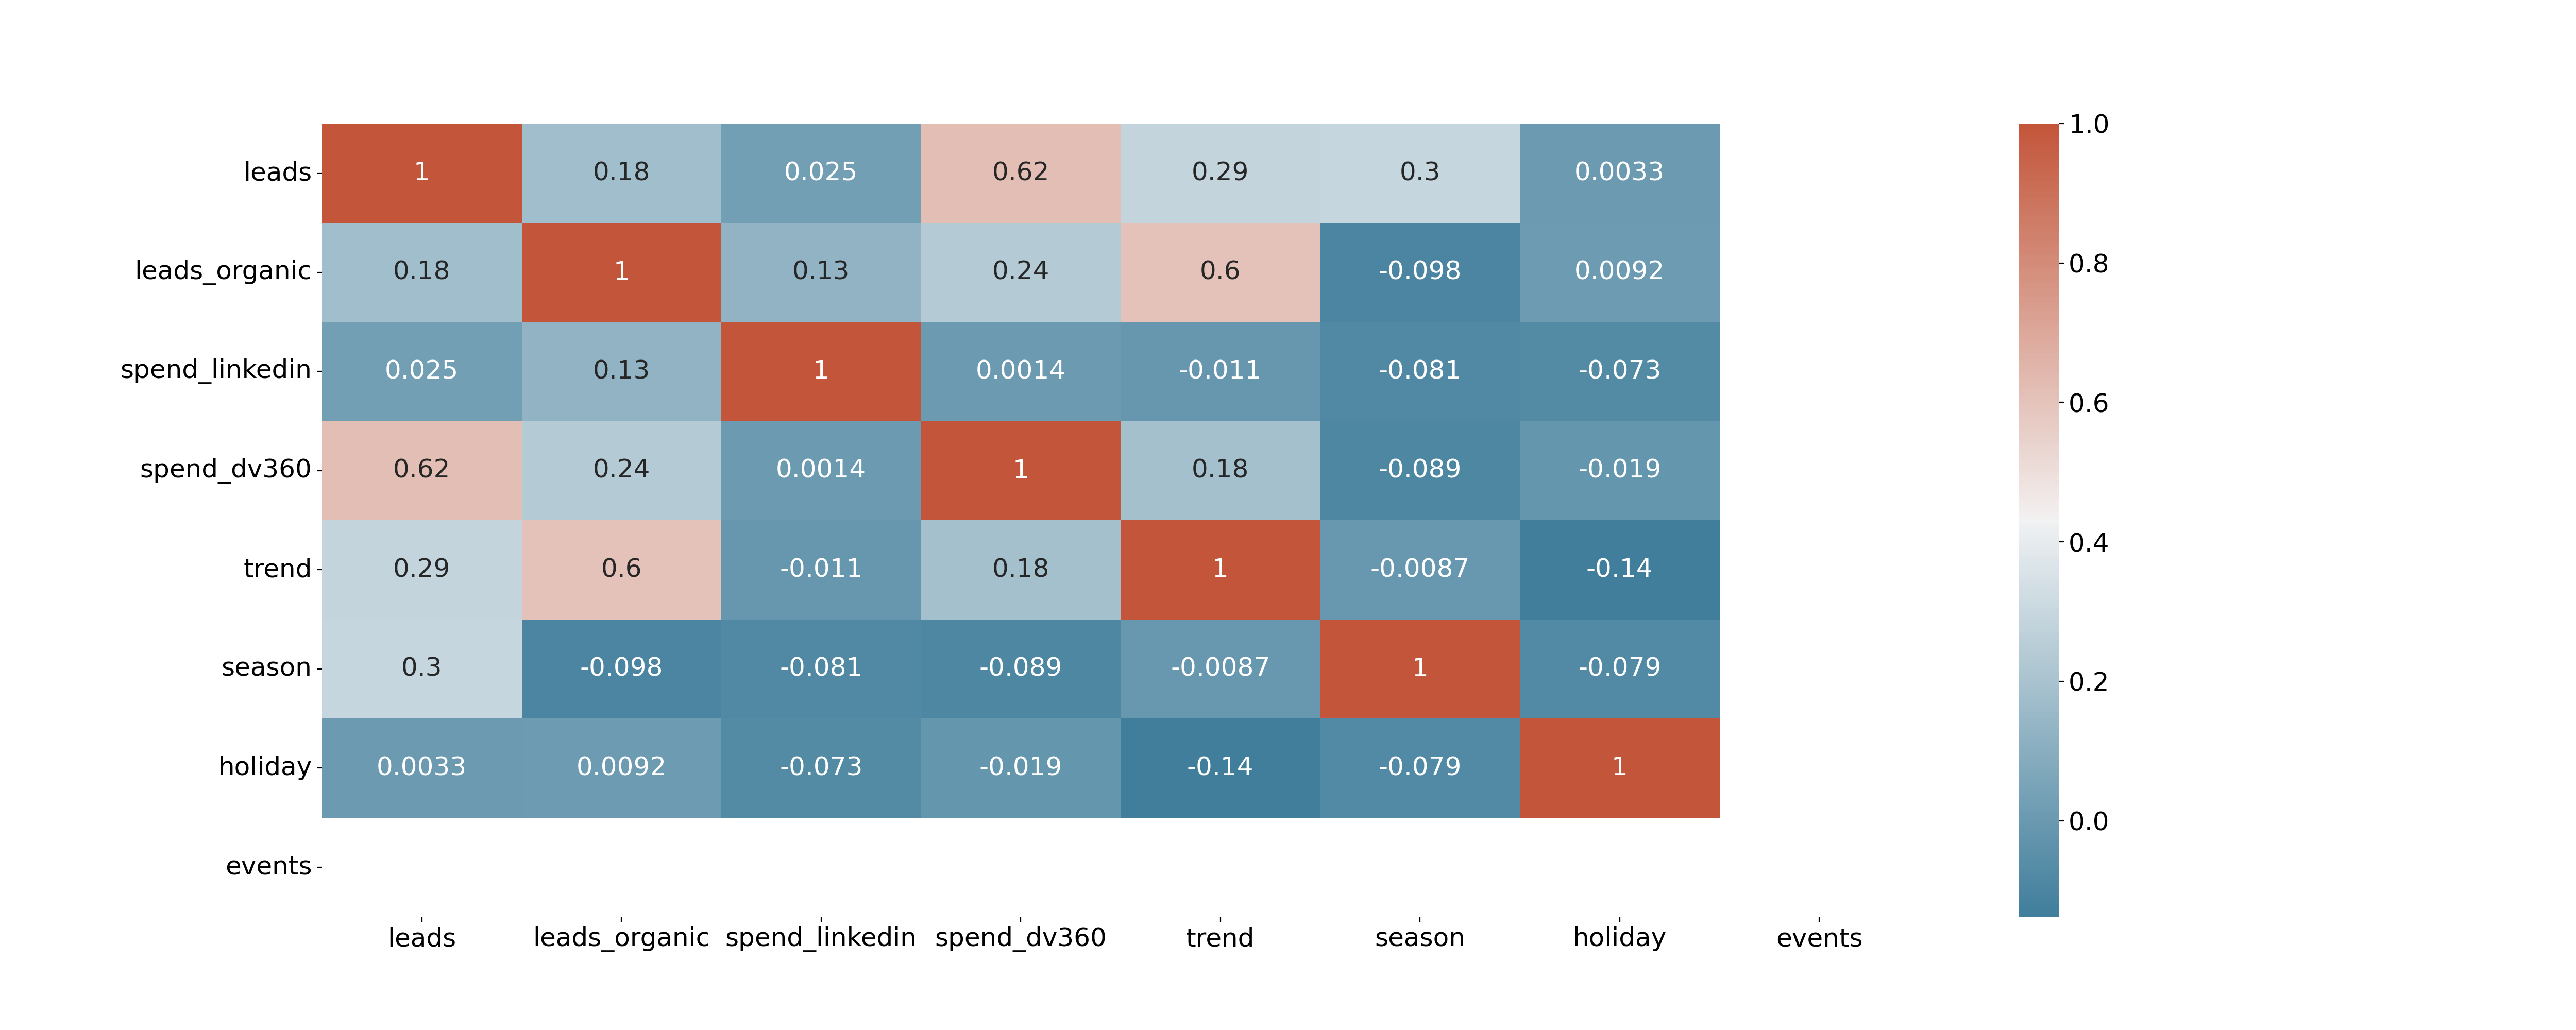

In [122]:
# The correlation plot was made to evaluate correlation betwwen the potential features. The reason behind the use of a corrplot
#is that I wanted to make sure none of the explanatory variables were highly correlated. As we know, this could lead to multicolinearity
#which, depending on the type of algorithm trained, may bias the model
#However, one effect which is certain is that highly correlated features lead to data-redundancy, which means that our computer will be exerting 
#more computing power for nothing.

corr = data_pr.corr()


fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap= sns.diverging_palette(230, 20, as_cmap=True))

## Correlation matrix analysis: 
As we can see, the correlation matrix does not indicate any high correlations between explanatory variables. Also, another interesting find is the fact that the seasonality feature is not highly correlated to the different spend features, which may indicate that seasonality is not calculated as a direct consequence of the spend on each channel. However, after discussions with Talha, it is likely that the seasonailty aspect truly is a factor influenced by spend. We will get our answers once we get more context to the data structure!!

## Model Development: what tools/processes will we use

1) Using Scikit-Learn: 
As you probably already know, Scikit-Learn is a Python library which enables the deployment of various machine learning models in an intuitive and user freindly manner

2) Using custom transformers for data processing: 
You might already know this, but in advertising, advertising spend's effect is usually not always fully manifest during the timeframe it was initially meant for. Here is a simple analogy to understand my statement: if I am Niantic (the company that runs Pokemon) and I run ads on YouTube for the latest Pokemon game for 2 weeks, and an 8 year-old child sees it. He might not take action to buy the game within that two week timespan, but might buy it 4 weeks later, way after the investment in the YouTube ad has ended. However, it is that advertisment that pushed him to purchase the game. This logic can be applied to leads as well: a user might see a past campaign for Mercedes and feel interested, but not sign up for a test drive directly from the ad. After 2 weeks, he might see a different ad for Mercedes and think "ah, well since there's a link let me click it, I want to signup to test that car I first saw the ad for a couple of weeks ago too'. In this case, the lead should at least be partially attributed to the spend on that first ad the consumer saw!

Therefore, this sale click be attributed to past campaign, and not to the campaign that is currently running. In order to statistically replicate this effect, marketing data scientists include a custom transformer in the preprocessing of their data called the Adstock effect, which replicates the carry-over by adding to each spend entry a fraction of past spend entries. The fraction of spend which is added depends on a fluctuating factor for which the right value will be determined during the optimisation phase of our model training. In the case of social media advertisements, I have limite the carry-over (also called time-decay) effect to 1 week, due to the ffast paced nature and information saturation of social media and user lower information retention

3) Using Optuna:
Optuna is an open source hyperparameter optimization framework to automate hyperparameter search. The reason Optuna search is- in my opinion the best hypeparameter optimization framework is because it cures the incoveniences of the two other major optimization frameworks used in python : GridSearch and RandomisedSearch.

For all frameworks, the Data Scientist must define the different intervals of values for the frameworks to test out for each parameter, however, for GridSearch, the framework will test out every single hyperparameter combination and then will return the best one. However, the multiple hyperparameter combinations makes GridSearches very long and tedious

For RandomisedSearch, the framework will just try out a bunch of random hyperparameter combinations (here, the coder will have to define a number of combination trials), and then returns the highest performing combination. This is less tedious than the GridSearch, but a drawback is that there is no guarantee that the highest performing model out of all the trials made is actually THE best hyperparameter combination out there!

For Optuna, the method is different: The algorithm first starts out testing out random combinations, but, over time, it starts "learning" by progressively memorizing the hyperparameter values that yield the highest performances. Therefore, the learning factor ensures that you end up with the best hyperparameter values (contrarily to RandomisedSearch) without having to compute all possible combinations like the GridSearch does

4) Using Shap: 
SHAP (SHapley Additive exPlanations) values are a concept from cooperative game theory that has been adapted for use in machine learning and interpretability. SHAP values provide a way to understand the contribution of individual features in a model's output for a specific instance or prediction. In this case, each player represents the different features of the dataset, and the outcome of the game is the target variable (=clicks)

SHAP values have several useful properties that make them effective for interpreting models:

Additivity
SHAP values are additive, which means that the contribution of each feature to the final prediction can be computed independently and then summed up. This property allows for efficient computation of SHAP values, even for high-dimensional datasets.

Local accuracy
SHAP values add up to the difference between the expected model output and the actual output for a given input. This means that SHAP values provide an accurate and local interpretation of the model's prediction for a given input.

Missingness
SHAP values are zero for missing or irrelevant features for a prediction. This makes SHAP values robust to missing data and ensures that irrelevant features do not distort the interpretation.

Consistency
SHAP values do not change when the model changes unless the contribution of a feature changes. This means that SHAP values provide a consistent interpretation of the model's behavior, even when the model architecture or parameters change.

Overall, SHAP values provide a consistent and objective way to gain insights into how a machine learning model makes predictions and which features have the greatest influence.

Link to better understand SHAP: https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

In [123]:
import shap

In [140]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted

#Adstock function implementation: to do so, I created a new class with contains methods that will transform the data and preprocess it
class AdstockGeometric(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.5):
        self.alpha = alpha
        
    """The following function generally checks if the format of the input data is 
    suitable for transformation"""
    def fit(self, X, y=None):
        #The check_array() function takes the X input (the data we want to apply the Adstock to) and checks if it's in the right format (either)
        #a Numpy array or a Pandas dataframe. If it isn't, it will convert it and updates the value of the X input
        X = check_array(X)

        #The check_n_features is a private method that will take the original X input (represented by 'self'), and checks if the updated X input
        #has the same number of features as the original input. Once the check is done, the method returns the original input as it is ready to 
        #be transformed!
        self._check_n_features(X, reset=True)
        return self
    

    """The following function rechecks for fitting and then creates a new dataframe
    the values of the new dataframe are equal to the values of the original input
    to which we add a fraction of the value of the previous period. The fraction
    is equal to the product of the previous value and an arbitrary coefficient"""
    def transform(self, X: np.ndarray):
        #This line checks whether the data has been fitted (so put through the fit function)
        check_is_fitted(self)
        #The check_array() function takes the the X input (the data we want to apply the Adstock to) and checks if it's in the right format (either)
        #a Numpy array or a Pandas dataframe. If it isn't, it will convert it and updates the value of the X input
        X = check_array(X)

        #The check_n_features is a private method that will take the original X input (represented by 'self'), and checks if the updated X input
        #has the same number of features as the original input. Once the check is done, the method returns the original input as it is ready to 
        #be transformed!
        self._check_n_features(X, reset=False)

        #This function creates a new numpy array which has the same dimentions as the input dataset but is filled with zeroes
        #This new array will store the transformed values of the X input array
        x_decayed = np.zeros_like(X)

        #Because the time decay effect updates a given value based on past values, you cannot apply it to the first row of the dataset since
        #there are no past values to create the effect with. Therefore, the first row of the x_decayed array will equal the first row of the input 
        x_decayed[0] = X[0]
        
        #for every other row of the input, we want the values of this row to equal to the value of the original input augmented by the product
        #of the previous row value and the alpha coefficient
        for xi in range(1, len(x_decayed)):
            x_decayed[xi] = X[xi] + self.alpha* x_decayed[xi - 1]
        return x_decayed

#This function computes the Normalized Root Mean Squared Error
def nrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))

#https://github.com/facebookexperimental/Robyn
def rssd(effect_share, spend_share):
    """RSSD decomposition
    
    Decomposition distance (root-sum-square distance, a major innovation of Robyn) 
    eliminates the majority of "bad models" 
    (larger prediction error and/or unrealistic media effect like the smallest channel getting the most effect

    Args:
        effect_share ([type]): percentage of effect share
        spend_share ([type]): percentage of spend share

    Returns:
        [type]: [description]
    """
    return np.sqrt(np.sum((effect_share - spend_share) ** 2))


"""This function allows to plot the the effect shares and spend shares to gain
a clearer understanding of the data and budget attributions"""
def plot_spend_vs_effect_share(decomp_spend: pd.DataFrame, figure_size = (15, 10)):
    """Spend vs Effect Share plot

    Args:
        decomp_spend (pd.DataFrame): Data with media decompositions. The following columns should be present: media, spend_share, effect_share per media variable
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).

    Example:
        decomp_spend:
        media         spend_share effect_share
        tv_S           0.31        0.44
        ooh_S          0.23        0.34
    
    Returns:
        [plotnine]: plotnine plot
    """
    
    plot_spend_effect_share = decomp_spend.melt(id_vars = ["media"], value_vars = ["spend_share", "effect_share"])

    plt = ggplot(plot_spend_effect_share, aes("media", "value", fill = "variable")) \
    + geom_bar(stat = "identity", position = "dodge") \
    + geom_text(aes(label = "value * 100", group = "variable"), color = "darkblue", position=position_dodge(width = 0.5), format_string = "{:.2f}%") \
    + coord_flip() \
    + ggtitle("Share of Spend VS Share of Effect") + ylab("") + xlab("") \
    + theme(figure_size = figure_size, 
                    legend_direction='vertical', 
                    legend_title=element_blank(),
                    legend_key_size=20, 
                    legend_entry_spacing_y=5) 
    return plt

def calculate_spend_effect_share(df_shap_values: pd.DataFrame, media_channels, df_original: pd.DataFrame):
    """
    Args:
        df_shap_values: data frame of shap values
        media_channels: list of media channel names
        df_original: non transformed original data
    Returns: 
        [pd.DataFrame]: data frame with spend effect shares
    """
    #Extract the sum of each effect share for each media variable from the shap values extracted
    responses = pd.DataFrame(df_shap_values[media_channels].abs().sum(axis = 0), columns = ["effect_share"])
    #Divide each sum per media by the sum of all shap values accross all media channels, and store all resulting values as a dataframe
    response_percentages = responses / responses.sum()
    response_percentages

    #Compute the some of the total spend per media channel in the original dataset by the total summ of all spend accross all channels, and store all resulting values as a dataframe
    spends_percentages = pd.DataFrame(df_original[media_channels].sum(axis = 0) / df_original[media_channels].sum(axis = 0).sum(), columns = ["spend_share"])
    spends_percentages

    #Create a consolidated dataset that contains the effect share and spend shares for each channel
    spend_effect_share = pd.merge(response_percentages, spends_percentages, left_index = True, right_index = True)
    spend_effect_share = spend_effect_share.reset_index().rename(columns = {"index": "media"})
    
    return spend_effect_share


#https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

""" This function plots the feature importance of every feature"""
def shap_feature_importance(shap_values, data, figsize = (20, 10)):
    #this line creates a list comprising of the column labels of the input data
    feature_list = list(data.columns)
    
    #The following block of code takes the SHAP values and checks whether they are 
    #contained in a dataframe format. If they aren't, the shap_values variable is 
    #transformed into a dataframe and renamed shap_v
    if isinstance(shap_values, pd.DataFrame) == False:
        shap_v = pd.DataFrame(shap_values)
        shap_v.columns = feature_list
    else:
        shap_v = shap_values
    
    #take in the input data, copy it, reset the index on that copy, and store it as
    #df_v
    df_v = data.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()

    feature_list.remove('month')
    feature_list.remove('year')
    
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plotting

    #we create a version of tha shap values dataset with only the absolute values
    shap_abs = np.abs(shap_v)
    #Compute the mean absolute Shap Value for each feature for every input feature
    #and store the results in a datasets
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    #create a consolidated dataset k2 which, for each row, contains the correlation 
    #between a feature column and its shap values, the absolute mean shap value,
    #and the color it should be plotted in (if the correlation is positive or neg)
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    #plot the k2 dataframe's absolute mean value and the variable name, in red or
    #blue according to if correlation was >0 or not
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=figsize,legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

 #This function applies the trained model to the data whilst including all
 #of the best hyperparameters found during the optuna search   
def model_refit(data, 
                target, 
                features, 
                media_channels,
                organic_channels,  
                model_params, 
                adstock_params, 
                start_index, 
                end_index):
    data_refit = data.copy()

    best_params = model_params

    adstock_alphas = adstock_params

    #apply adstock transformation
    for feature in media_channels + organic_channels:
        adstock_alpha = adstock_alphas[feature]
        print(f"applying geometric adstock transformation on {feature} with alpha {adstock_alpha}") 

        #adstock transformation
        x_feature = data_refit[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        data_refit[feature] = temp_adstock

    #build the final model on the data until the end analysis index
    x_input = data_refit.loc[0:end_index-1, features]
    y_true_all = data[target].values[0:end_index]

    #build random forest using the best parameters
    random_forest = RandomForestRegressor(random_state=0, **best_params)
    random_forest.fit(x_input, y_true_all) 


    #concentrate on the analysis interval
    y_true_interval = y_true_all[start_index:end_index]
    x_input_interval_transformed = x_input.iloc[start_index:end_index]

    #revenue prediction for the analysis interval
    print(f"predicting {len(x_input_interval_transformed)}")
    prediction = random_forest.predict(x_input_interval_transformed)

    #transformed data set for the analysis interval 
    x_input_interval_nontransformed = data.iloc[start_index:end_index]


    #shap explainer 
    explainer = shap.TreeExplainer(random_forest)

    # get SHAP values for the data set for the analysis interval from explainer model
    shap_values_train = explainer.shap_values(x_input_interval_transformed)

    # create a dataframe of the shap values for the training set and the test set
    df_shap_values = pd.DataFrame(shap_values_train, columns=features)
    
    return {
            'df_shap_values': df_shap_values, 
            'x_input_interval_nontransformed': x_input_interval_nontransformed, 
            'x_input_interval_transformed' : x_input_interval_transformed,
            'prediction_interval': prediction, 
            'y_true_interval': y_true_interval, 
            'model_used':random_forest
           }

def predict_prophet(start_date,
            periods,            
            spend_linkedin,
            spend_dv360):

    #Creation of an automated list of week_end dates. the number of weeks covered depends on user input for the periods variable
    media_channels=['spend_linkedin','spend_dv360']
    future_dates = pd.date_range(start=start_date, periods=periods, freq="W")  # Weekly frequency

   
    entry = {
            "spend_linkedin": [spend_linkedin] * periods,
            "spend_dv360": [spend_dv360] * periods
        }

    #Creation of the dataframe, which will contain for every record of a given week the end of week date + the value of the weekly investment for 
    #each channel
    future_data = pd.DataFrame({
            "ds": future_dates,
            **entry
        })

    #Calling the model_predict_prophet function that will take the formed dataset as input and predict the clicks value taking into account the 
    #weekly budget allocated in the entre dataset! It will predict the clicks using a model trained on the training data

    prediction = model_predict_prophet(data=data_pr,
                        entry=future_data,
                        target=target,  
                        media_channels=media_channels,  
                        adstock_params=adstock_params)

    #Return the prediction!
    return prediction

    #this function will train a prophet model on the training dataset (to which we incorporated carry-over effect found using the MMM) 
    #to predict the clicks based on the channel spends indicated in the new entry
    #dataset (to which carry-over is also applied!!)
def model_predict_prophet(data,
                entry,
                target,  
                media_channels,   
                adstock_params):


    data_refit = data.copy()

    entry_refit= entry.copy()

    adstock_alphas = adstock_params

    
    data_refit['ds']=data_refit['week_end']
    data_refit['y']=data_refit['leads']


    #apply adstock transformation
    for feature in media_channels:
        adstock_alpha = adstock_alphas[feature]
        
        #adstock transformation
        x_feature = data_refit[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        data_refit[feature] = temp_adstock

        print(f"successfully applied {adstock_alpha} adstock on {feature} ") 

    print("Successfully applied adstock to training data") 


    #build prophet model on transformed training data, The add method allows to take into account external factors!

    prophet_predict= Prophet(weekly_seasonality=True)
    prophet_predict.add_country_holidays(country_name='AE')
    prophet_predict.add_regressor(name = "spend_linkedin")
    prophet_predict.add_regressor(name = "spend_dv360")

    #Fitting the Prophet algorithm to our dataset
    prophet_predict.fit(data_refit[["ds", "y", "spend_linkedin", "spend_dv360"]])



    #concentrate on the entry data
    if len(entry)>1: 

        #apply adstock transformation
        for feature in media_channels:
            adstock_alpha = adstock_alphas[feature]

            #adstock transformation
            x_entry_feature = entry_refit[feature].values.reshape(-1, 1)
            temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_entry_feature)
            entry_refit[feature] = temp_adstock

            print(f"successfully applied {adstock_alpha} adstock on {feature} ") 

        print("successfully applied alpha adstock on media spends based on which we want to carry out predictions") 

        #revenue prediction for the analysis interval
        print(f"predicting {len(entry_refit)} weeks worth of Leads based on inputed variables :) ")
        #making the model predict the values of clicks based on the algorithm that has been trained and fitted to the historical clicks values
            
        prophet_predict_data = prophet_predict.predict(entry_refit)

        prediction = prophet_predict_data["yhat"]


        predicted_results = pd.DataFrame({
            "ds": entry['ds'],
            "predicted_leads": prediction
        })

    else: 

        #revenue prediction for the analysis interval
        print(f"predicting {len(entry_refit)} weeks worth of Leads based on inputed variables :) ")

        #making the model predict the values of clicks based on the algorithm that has been trained and fitted to the historical clicks values
        prophet_predict_data = prophet_predict.predict(entry_refit)

        prediction = prophet_predict_data["yhat"]


        predicted_results = pd.DataFrame({
            "ds": entry['ds'],
            "predicted_leads": prediction
        })

    return predicted_results

 #This function plots individual visualisations for each input feature of the spend 
 #of the transformed input data vs the corresponding shapey value for each row of the
 #dataset



def plot_shap_vs_spend(df_shap_values, x_input_interval_nontransformed, x_input_interval_transformed, features, media_channels, figsize=(25, 10)):
    for channel in media_channels:
    
        index = features.index(channel)
        #for every feature of the input data, we extract the mean spend
        #from the untransformed input dataset to plot it as a threshold in the final
        #plots. The mean does not take into account 0 spend values!
        mean_spend = x_input_interval_nontransformed.loc[x_input_interval_nontransformed[channel] > 0, channel].mean()

        fig, ax = plt.subplots(figsize=figsize)
        sns.regplot(x = x_input_interval_transformed[channel], y = df_shap_values[channel], label = channel,
                    scatter_kws={'alpha': 0.65}, line_kws={'color': 'C2', 'linewidth': 6},
                    lowess=True, ax=ax).set(title=f'{channel}: Spend vs Shapley')
        ax.axhline(0, linestyle = "--", color = "black", alpha = 0.5)
        ax.axvline(mean_spend, linestyle = "--", color = "red", alpha = 0.5, label=f"Average Spend: {int(mean_spend)}")
        ax.set_xlabel(f"{channel} spend")
        ax.set_ylabel(f'SHAP Value for {channel}')
        plt.legend()

In [125]:
"""This function carries out model hyperparameter optimisation using 2 objective
metrics: RMSE and the decomposed shared effect spend"""
def optuna_trial(trial, 
                 data:pd.DataFrame, 
                 target, 
                 features, 
                 adstock_features, 
                 adstock_features_params, 
                 media_features, 
                 tscv, 
                 is_multiobjective = False):
    
    data_temp = data.copy()
    adstock_alphas = {}
    
    #for every feature in the adstock_features list, we will randomly pick an 
    #alpha value that we will use to transform the values of the data using 
    #adstock transformer
    for feature in adstock_features:
        adstock_param = f"{feature}_adstock"
        min_, max_ = adstock_features_params[adstock_param]
        #The trial.suggest method suggests an alpha value between the minimum and 
        #maximum
        adstock_alpha = trial.suggest_uniform(f"adstock_alpha_{feature}", min_, max_)
        #The suggested adstock alpha is placed as a the dictionary value of the 
        #adstock alphas dictionary which corresponds to the corresponding feature
        #key
        adstock_alphas[feature] = adstock_alpha
        
        #for the given feature, we take it's column in the original data input
        #and reformat it as a 2D array.
        x_feature = data[feature].values.reshape(-1, 1)
        #We then apply the adstock transformation with the adstock alpha value we
        #stored in the dictionary
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        #We then update the data_temp values for the given feature
        data_temp[feature] = temp_adstock
        
        
    #Random Forest parameters
    n_estimators = trial.suggest_int("n_estimators", 5, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    max_depth = trial.suggest_int("max_depth", 4,7)
    ccp_alpha = trial.suggest_uniform("ccp_alpha", 0, 0.3)
    bootstrap = trial.suggest_categorical("bootstrap", [False, True])
    criterion = trial.suggest_categorical("criterion", ["squared_error"])  #"absolute_error"
    
    #Create these lists that will store the values of these model performance metrics
    #for every split of the time series cross validation
    scores = []
    
    rssds = []

    #extract the different indexes for the train and test splits of the Timeseries
    #cross validation to seperate and train the random forest on the transformed data
    for train_index, test_index in tscv.split(data_temp):
        x_train = data_temp.iloc[train_index][features]
        y_train =  data_temp[target].values[train_index]
        
        x_test = data_temp.iloc[test_index][features]
        y_test = data_temp[target].values[test_index]
        
        #apply Random Forest
        params = {"n_estimators": n_estimators, 
                   "min_samples_leaf":min_samples_leaf, 
                   "min_samples_split" : min_samples_split,
                   "max_depth" : max_depth, 
                   "ccp_alpha" : ccp_alpha, 
                   "bootstrap" : bootstrap, 
                   "criterion" : criterion
                 }
        
        #Carry out the  prediction of the test sets to evaluate the performance of 
        #the forest using the functions defined previously, store the values in the 
        #score list
        rf = RandomForestRegressor(random_state=0, **params)
        rf.fit(x_train, y_train)
        prediction = rf.predict(x_test)
        

        rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)
        scores.append(rmse)
        
        #If we were to train a multiobjective optimization, we optimize for RMSE
        #and RSSD
        if is_multiobjective:
            
            #set_trace()
            #calculate spend effect share -> rssd
            # create explainer model by passing trained model to shap
            explainer = shap.TreeExplainer(rf)

            # get Shap values
            shap_values_train = explainer.shap_values(x_train)
            
            df_shap_values = pd.DataFrame(shap_values_train, columns=features)

            spend_effect_share = calculate_spend_effect_share(df_shap_values = df_shap_values, media_channels = media_features, df_original = data.iloc[train_index])

            decomp_rssd = rssd(effect_share = spend_effect_share.effect_share.values, spend_share = spend_effect_share.spend_share.values)
            rssds.append(decomp_rssd)
    
    #Set the user attributes of the trial method as the parameters we set above to 
    #manage/update the optimization process
    trial.set_user_attr("scores", scores)
    
    trial.set_user_attr("params", params)
    trial.set_user_attr("adstock_alphas", adstock_alphas)

    #if our optimisation is not multiobjective, then we only optimise for the RMSE
    if is_multiobjective == False:
        return np.mean(scores)
    
    
    trial.set_user_attr("rssds", rssds)
        
    #multiobjective
    return np.mean(scores), np.mean(rssds)

In [138]:
#Creation of the the optimization pipeline
def optuna_optimize(trials, 
                    data: pd.DataFrame, 
                    target, 
                    features, 
                    adstock_features, 
                    adstock_features_params, 
                    media_features, 
                    tscv, 
                    is_multiobjective, 
                    seed = 42):
    print(f"data size: {len(data)}")
    print(f"media features: {media_features}")
    print(f"adstock features: {adstock_features}")
    print(f"features: {features}")
    print(f"is_multiobjective: {is_multiobjective}")
    opt.logging.set_verbosity(opt.logging.WARNING) 
    
    if is_multiobjective == False:
        study_mmm = opt.create_study(direction='minimize', sampler = opt.samplers.TPESampler(seed=seed))  
    else:
        study_mmm = opt.create_study(directions=["minimize", "minimize"], sampler=opt.samplers.NSGAIISampler(seed=seed))
        
    optimization_function = partial(optuna_trial, 
                                    data = data, 
                                    target = target, 
                                    features = features, 
                                    adstock_features = adstock_features, 
                                    adstock_features_params = adstock_features_params, 
                                    media_features = media_features, 
                                    tscv = tscv, 
                                    is_multiobjective = is_multiobjective)
    
    
    study_mmm.optimize(optimization_function, n_trials = trials, show_progress_bar = True)
    
    return study_mmm
    

In [127]:
#Running the optimisation function!
tscv = TimeSeriesSplit(n_splits=3, test_size = 20)

adstock_features_params = {}
adstock_features_params["spend_dv360_adstock"] = (0.1, 0.8)
adstock_features_params["spend_linkedin_adstock"] = (0.1, 0.8)
adstock_features_params["leads_organic_adstock"] = (0.1, 0.8)

OPTUNA_TRIALS = 2000
experiment = optuna_optimize(trials = OPTUNA_TRIALS, 
                             data = data_pr, 
                             target = target,
                             features=features,
                             adstock_features = media_channels + organic_channels, 
                             adstock_features_params = adstock_features_params, 
                             media_features=media_channels, 
                             tscv = tscv, 
                             is_multiobjective=False)

data size: 188
media features: ['spend_linkedin', 'spend_dv360']
adstock features: ['spend_linkedin', 'spend_dv360', 'leads_organic']
features: ['trend', 'season', 'holiday', 'events', 'month', 'year', 'spend_linkedin', 'spend_dv360', 'leads_organic']
is_multiobjective: False


  0%|          | 0/2000 [00:00<?, ?it/s]suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Best trial: 0. Best value: 2160.28:   0%|          | 1/2000 [00:00<05:04,  6.55it/s]suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform 

In [128]:
#Extract the resulting study of the optuna search,
#which is where all the results are stored
experiment


In [129]:
experiment.best_trial.user_attrs["scores"]


[387.76038331854886, 378.53062573752794, 4206.240957434058]

In [130]:
experiment.best_trial.user_attrs["params"]


{'n_estimators': 52,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'max_depth': 6,
 'ccp_alpha': 0.04088064768803233,
 'bootstrap': False,
 'criterion': 'squared_error'}

In [131]:
experiment.best_trial.user_attrs["adstock_alphas"]


{'spend_linkedin': 0.6131622217633432,
 'spend_dv360': 0.17255318234981337,
 'leads_organic': 0.6130818531892193}

In [132]:
experiment.best_params


{'adstock_alpha_spend_linkedin': 0.6131622217633432,
 'adstock_alpha_spend_dv360': 0.17255318234981337,
 'adstock_alpha_leads_organic': 0.6130818531892193,
 'n_estimators': 52,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'max_depth': 6,
 'ccp_alpha': 0.04088064768803233,
 'bootstrap': False,
 'criterion': 'squared_error'}

In [133]:
experiment.best_trial


FrozenTrial(number=790, state=TrialState.COMPLETE, values=[1657.5106554967115], datetime_start=datetime.datetime(2023, 8, 24, 11, 32, 36, 180086), datetime_complete=datetime.datetime(2023, 8, 24, 11, 32, 36, 386134), params={'adstock_alpha_spend_linkedin': 0.6131622217633432, 'adstock_alpha_spend_dv360': 0.17255318234981337, 'adstock_alpha_leads_organic': 0.6130818531892193, 'n_estimators': 52, 'min_samples_leaf': 1, 'min_samples_split': 12, 'max_depth': 6, 'ccp_alpha': 0.04088064768803233, 'bootstrap': False, 'criterion': 'squared_error'}, user_attrs={'scores': [387.76038331854886, 378.53062573752794, 4206.240957434058], 'params': {'n_estimators': 52, 'min_samples_leaf': 1, 'min_samples_split': 12, 'max_depth': 6, 'ccp_alpha': 0.04088064768803233, 'bootstrap': False, 'criterion': 'squared_error'}, 'adstock_alphas': {'spend_linkedin': 0.6131622217633432, 'spend_dv360': 0.17255318234981337, 'leads_organic': 0.6130818531892193}}, system_attrs={}, intermediate_values={}, distributions={'a

## Model REFIT

In [134]:
#Apply the optimised model with all best hyperparameters to predict 
#the desired period of interest to analyze
best_params = experiment.best_trial.user_attrs["params"]
adstock_params = experiment.best_trial.user_attrs["adstock_alphas"]
result = model_refit(data = data_pr, 
                     target = target,
                     features = features, 
                     media_channels = media_channels,  
                     organic_channels = organic_channels, 
                     model_params = best_params, 
                     adstock_params = adstock_params, 
                     start_index = START_ANALYSIS_INDEX, 
                     end_index = END_ANALYSIS_INDEX)

applying geometric adstock transformation on spend_linkedin with alpha 0.6131622217633432
applying geometric adstock transformation on spend_dv360 with alpha 0.17255318234981337
applying geometric adstock transformation on leads_organic with alpha 0.6130818531892193
predicting 88


## METRICS

RMSE: 1282.1141387822968
MAPE: 5.4133143454887944e+16
NRMSE: 0.07330136291706002
R2: 0.8396740285190446


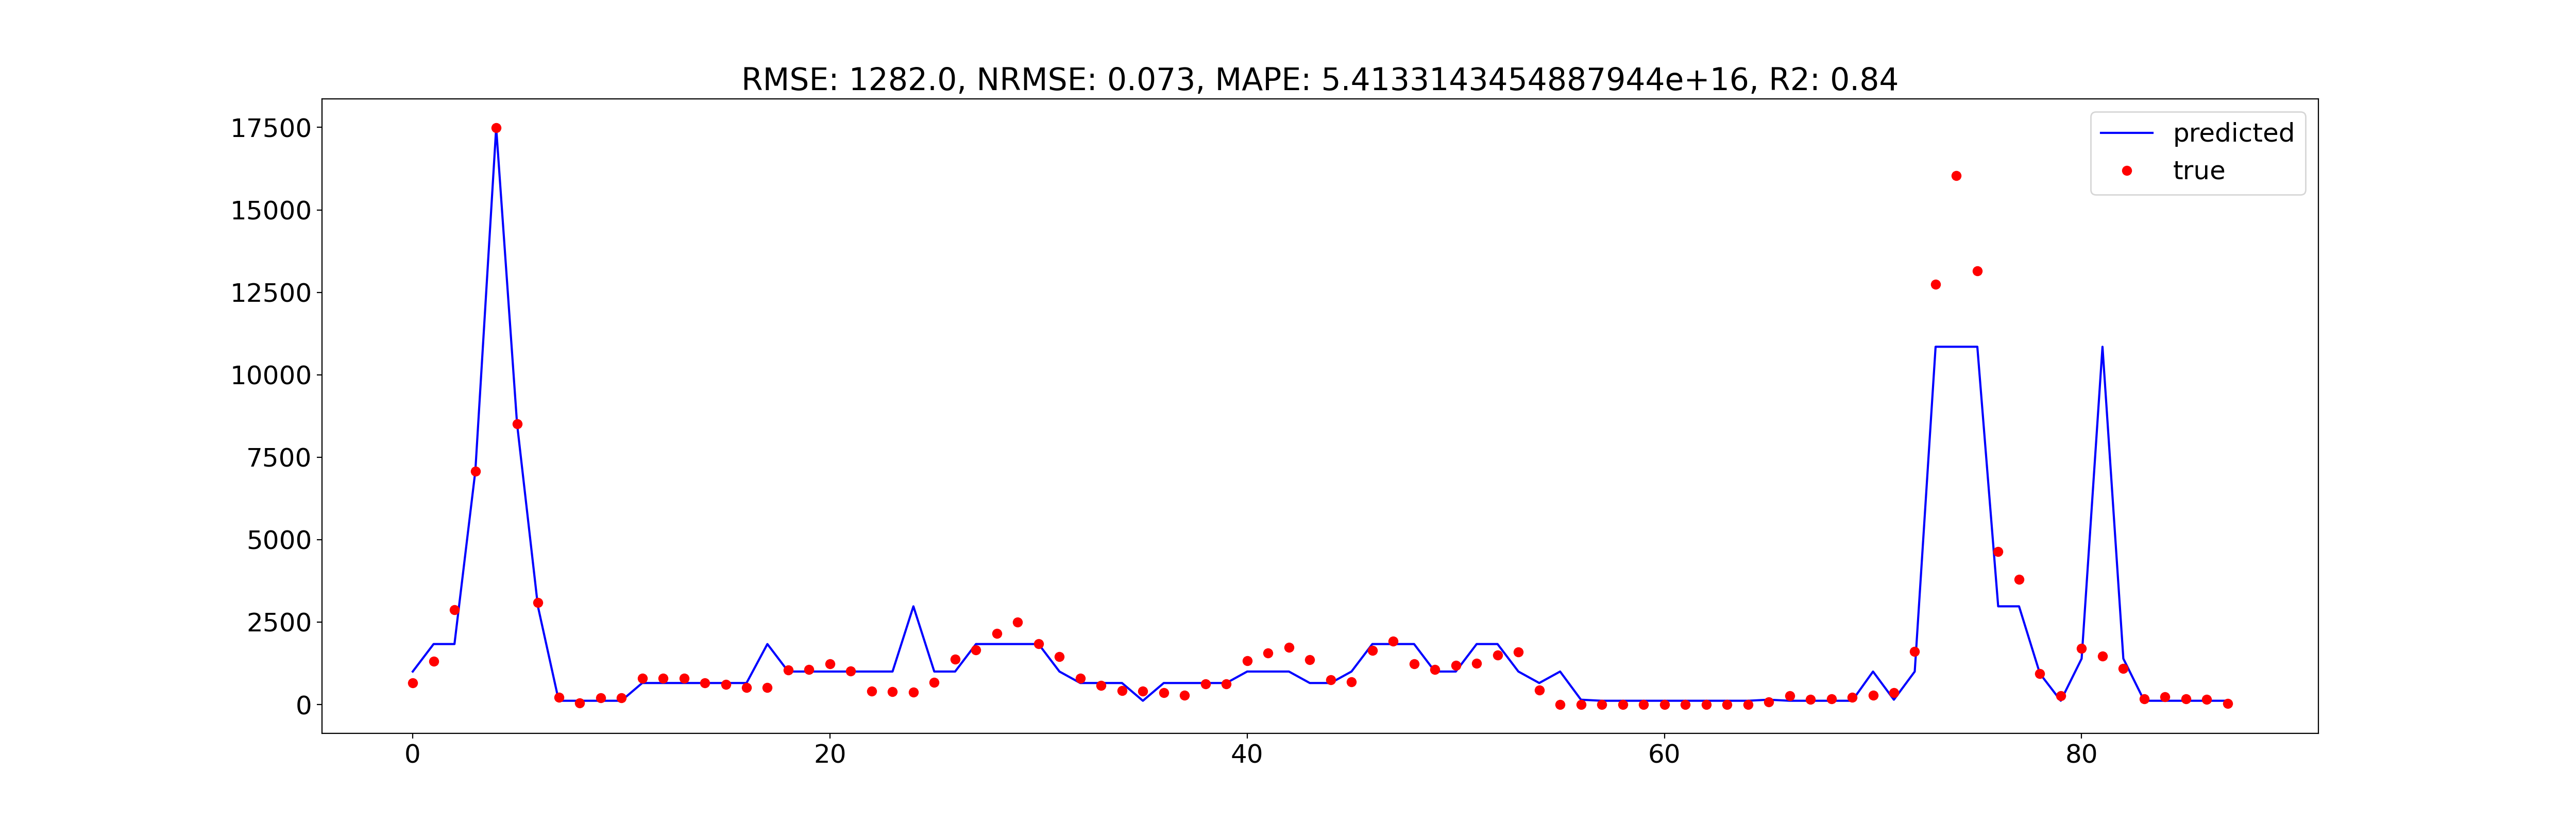

In [135]:
#extract the performannce metrics + plotting of the model accuracy

rmse_metric = mean_squared_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"], squared=False)
mape_metric = mean_absolute_percentage_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])
nrmse_metric = nrmse(result["y_true_interval"], result["prediction_interval"])
r2_metric = r2_score(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])

print(f'RMSE: {rmse_metric}')
print(f'MAPE: {mape_metric}')
print(f'NRMSE: {nrmse_metric}')
print(f'R2: {r2_metric}')


fig, ax = plt.subplots(figsize = (25, 8))
_ = ax.plot(result["prediction_interval"], color = "blue", label = "predicted")
_ = ax.plot(result["y_true_interval"], 'ro', label = "true")
_ = plt.title(f"RMSE: {np.round(rmse_metric)}, NRMSE: {np.round(nrmse_metric, 3)}, MAPE: {np.round(mape_metric, 3)}, R2: {np.round(r2_metric,3)}")
_ = ax.legend()

## Feature importance

Here we plot the feature imprtance, spend vs effect shares, and saturation using the functions defined above

invalid value encountered in divide
invalid value encountered in divide


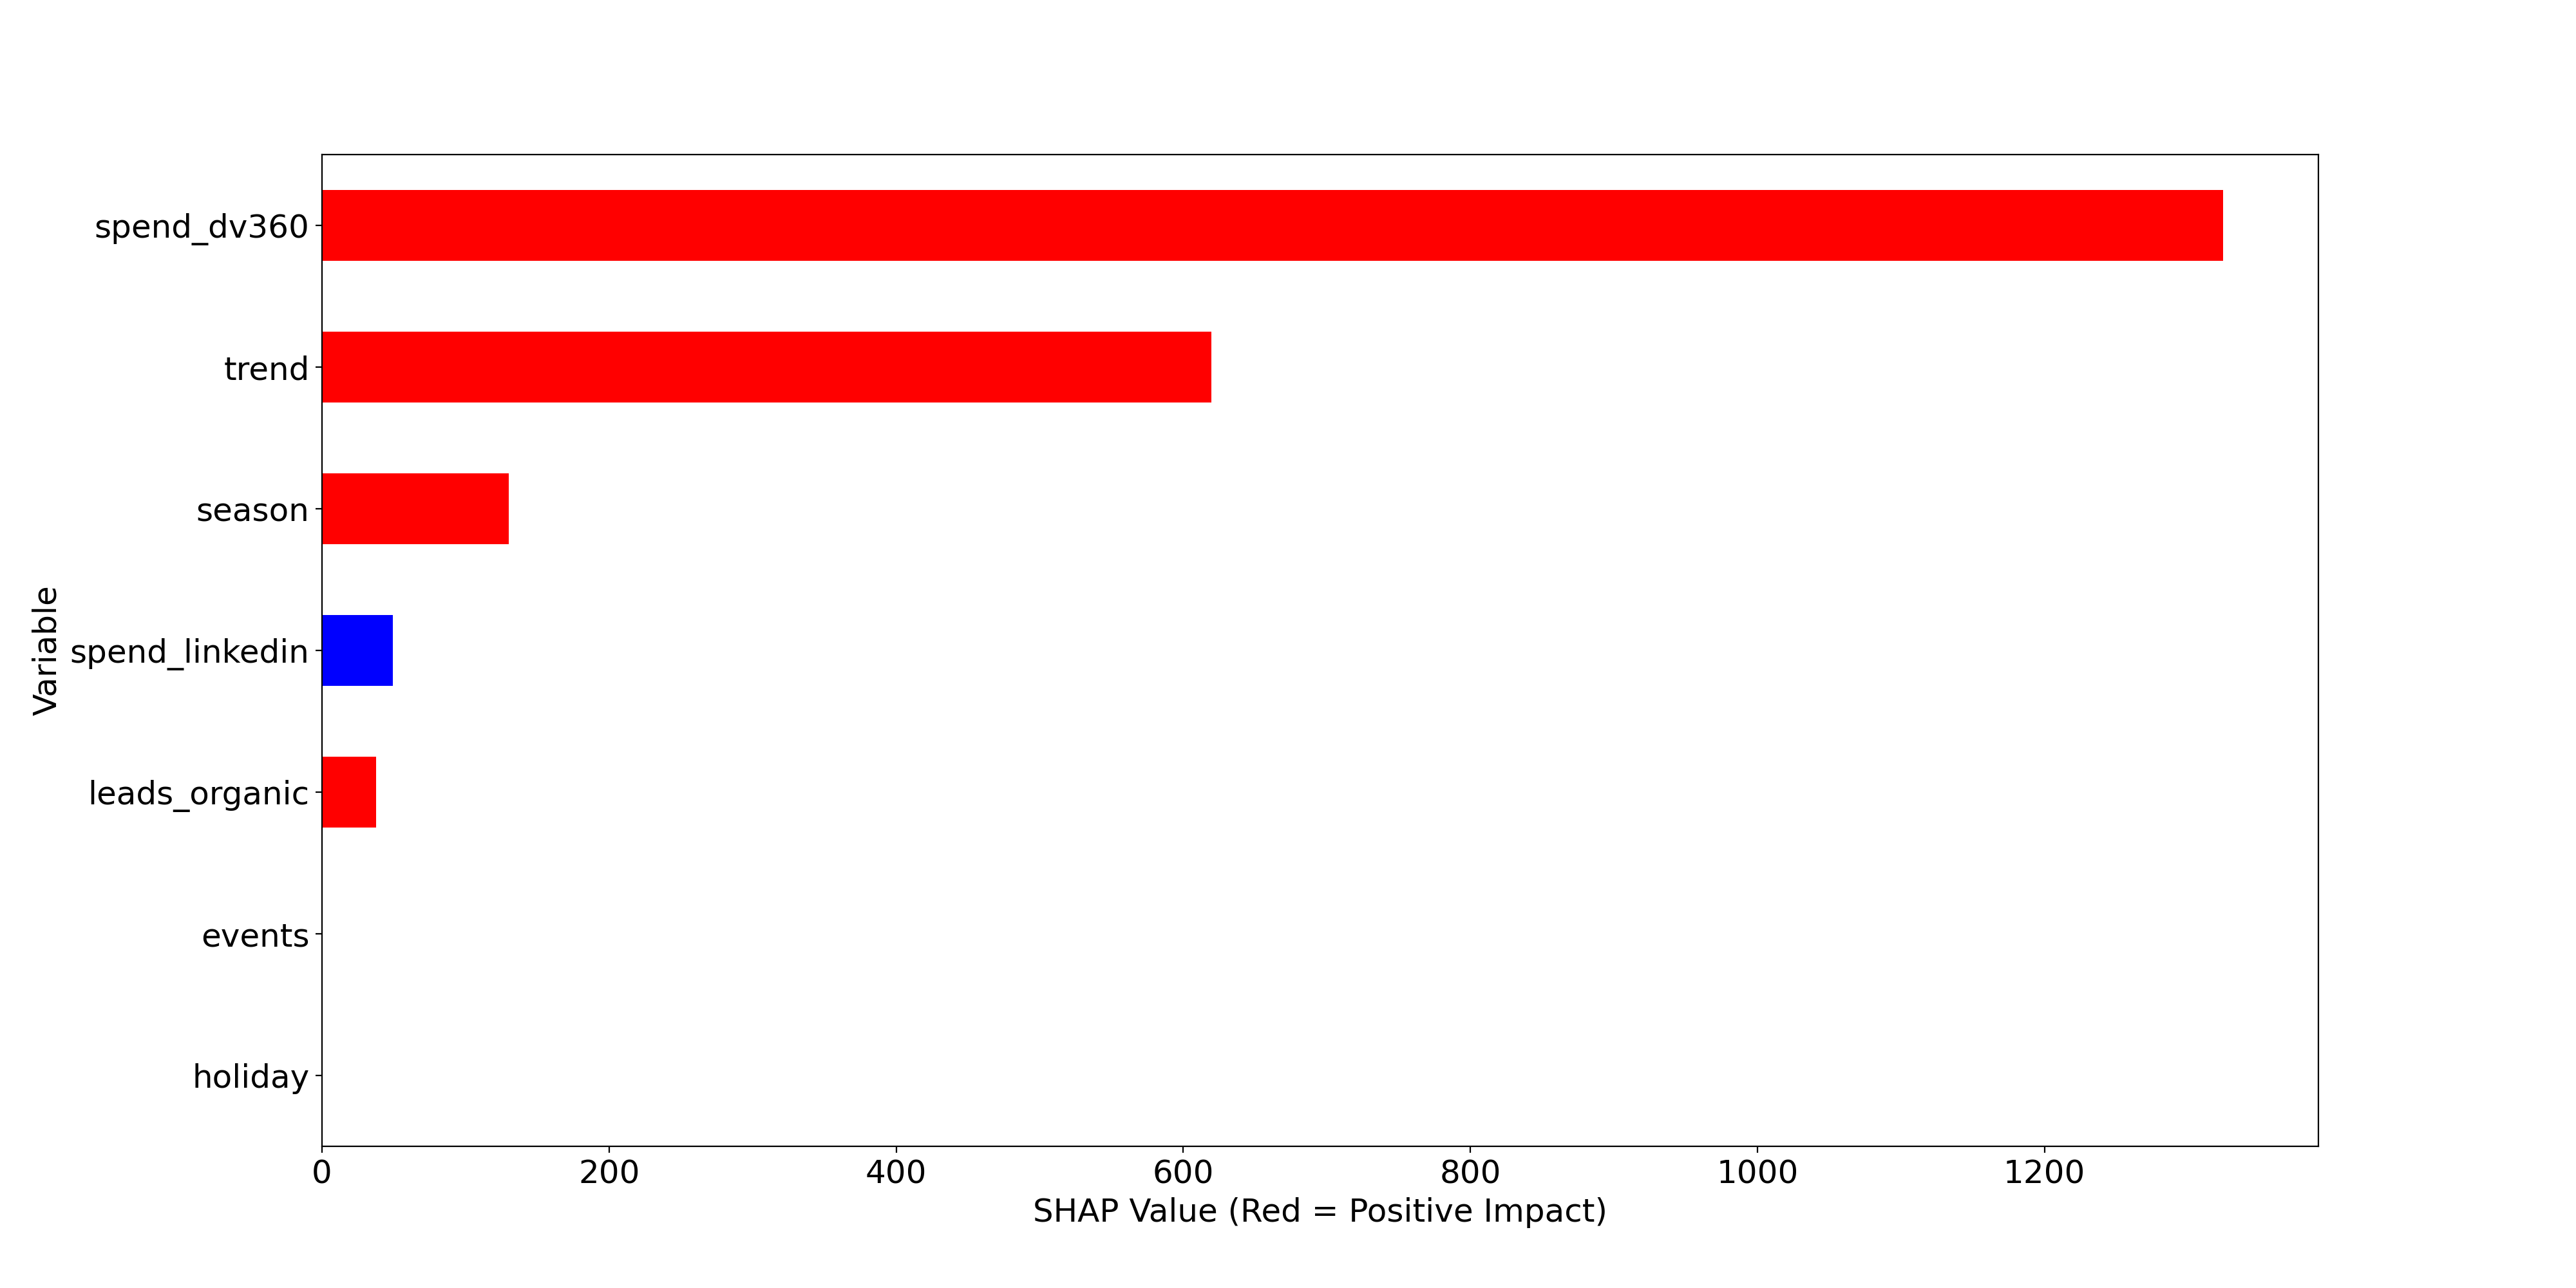

In [141]:
shap_feature_importance(result["df_shap_values"], result["x_input_interval_transformed"])


How do we interpret this? 

Let's take spend_dv360: given that the average leads prediction accross all predicted leads for every week of the analysis period dv360 has, on average, casued the prediction to be 1,300 higher than the average predicted leads value. Therefore, it has the biggest positive impact on our algorithms final prediction value

DECOMP.RSSD: 0.2471942817461148


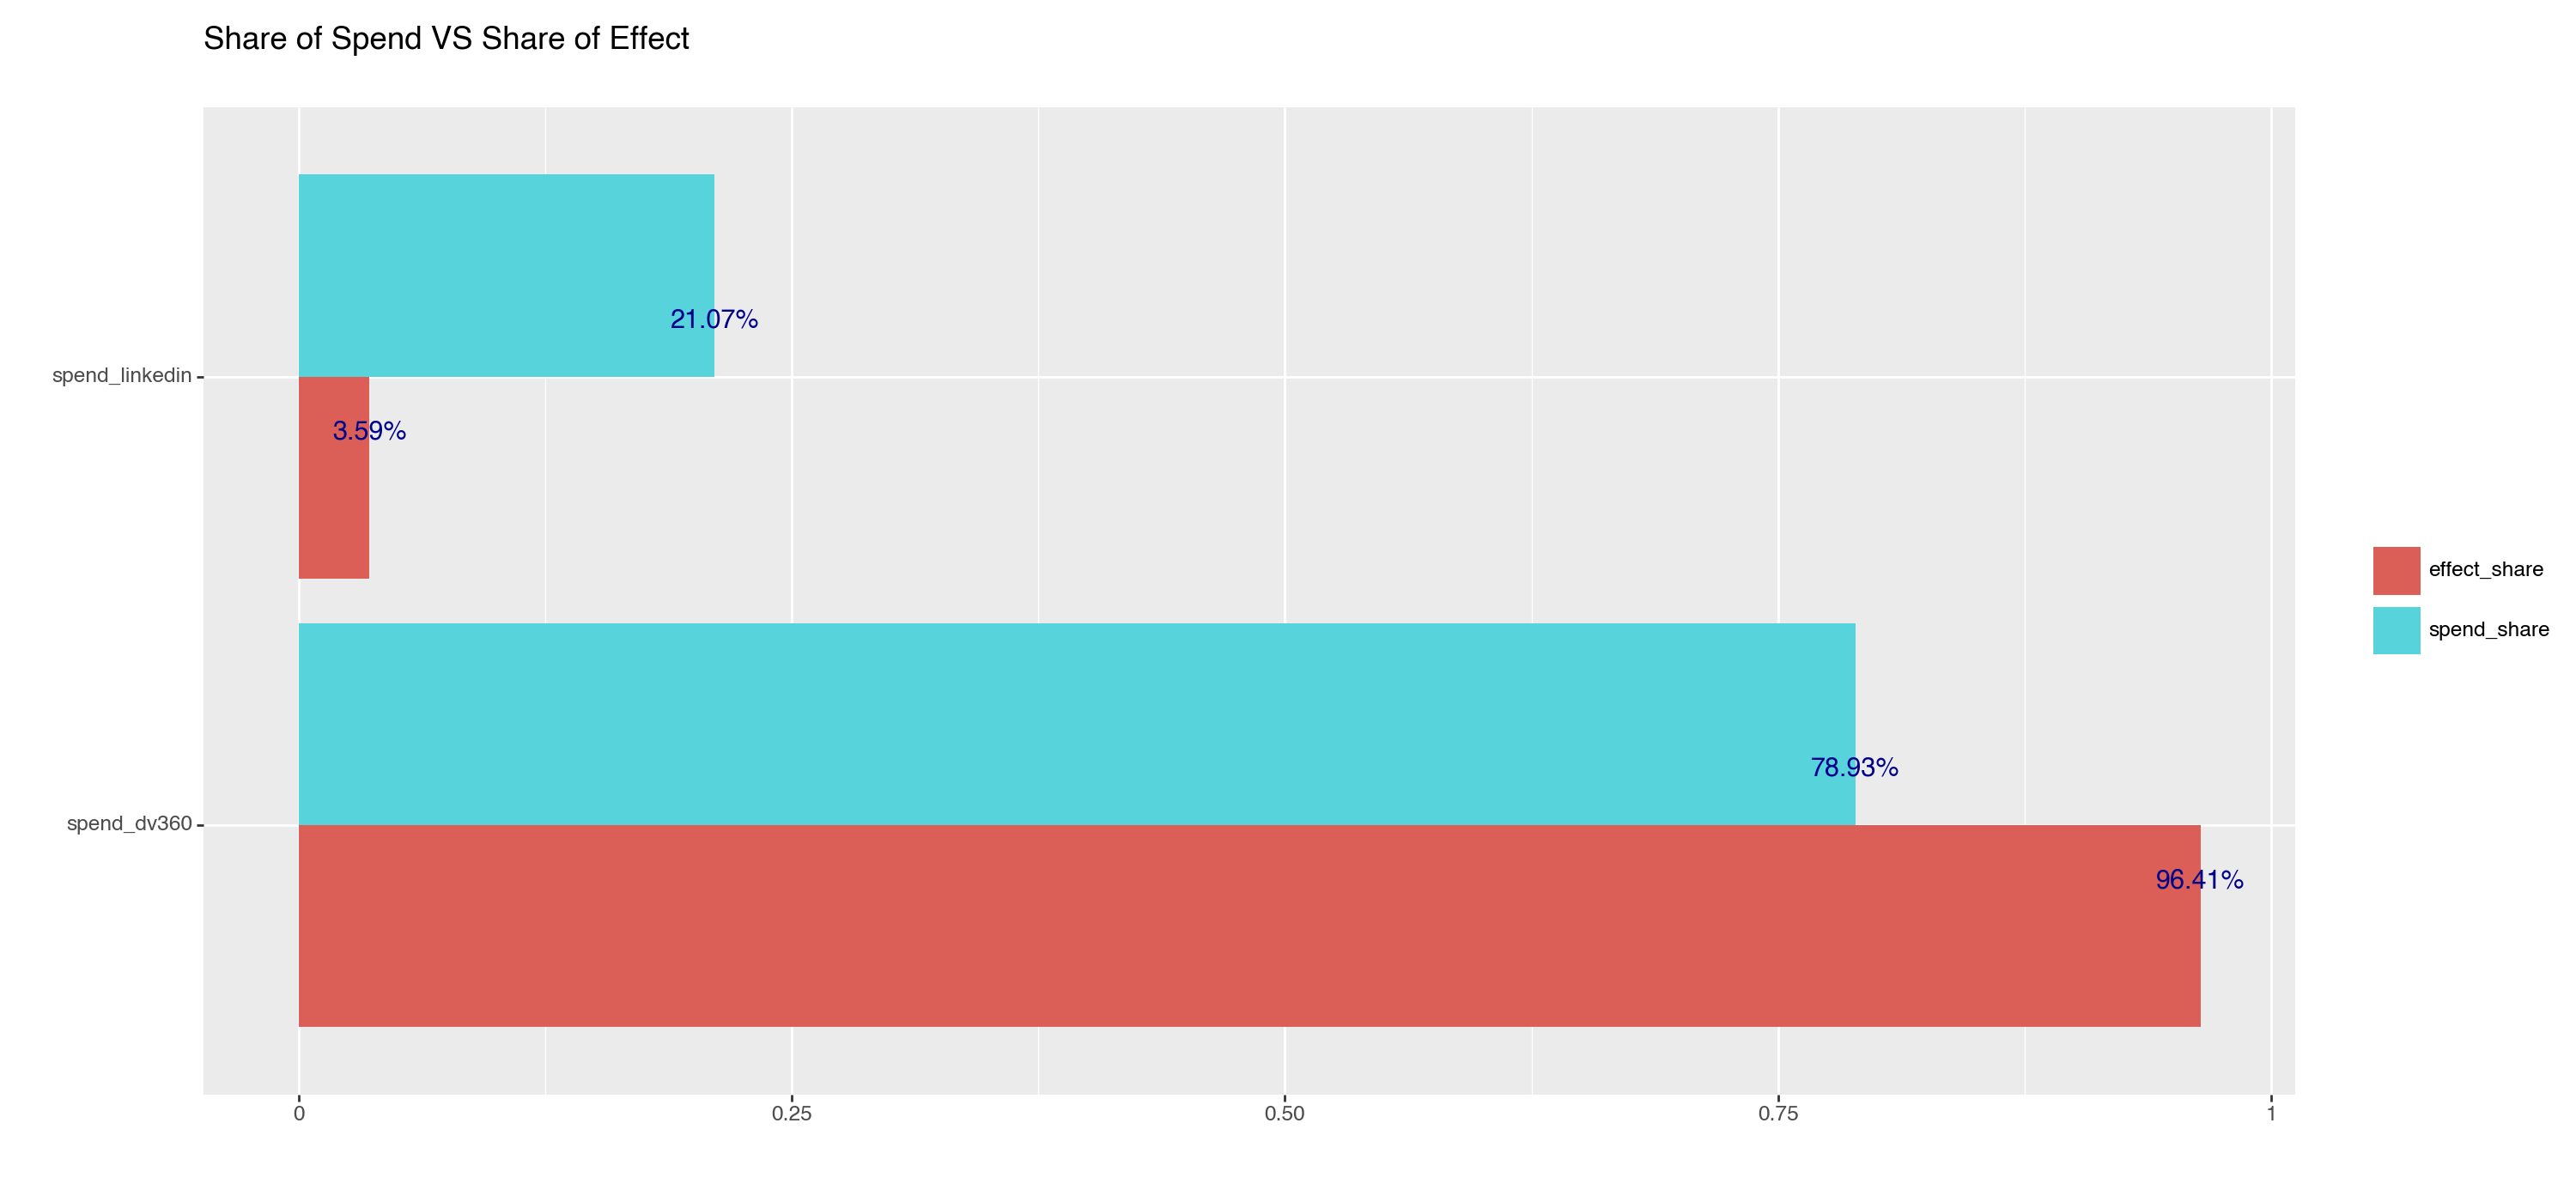

In [142]:
spend_effect_share = calculate_spend_effect_share(df_shap_values = result["df_shap_values"], media_channels = media_channels, df_original = result["x_input_interval_nontransformed"])

decomp_rssd = rssd(effect_share = spend_effect_share.effect_share.values, spend_share = spend_effect_share.spend_share.values)
print(f"DECOMP.RSSD: {decomp_rssd}")
print(plot_spend_vs_effect_share(spend_effect_share, figure_size = (15, 7)))

How do we interpret this? 

Let's take spend_dv360: given that the average clicks prediction accross all predicted clicks for every week of the analysis period dv360 has, on average, has contributed on average to 96.41% of the difference between predictions made and the average prediction accross all predictions. Comparatively, the average spend for a given ad record consititutes 78.93% of the total spend across all channels

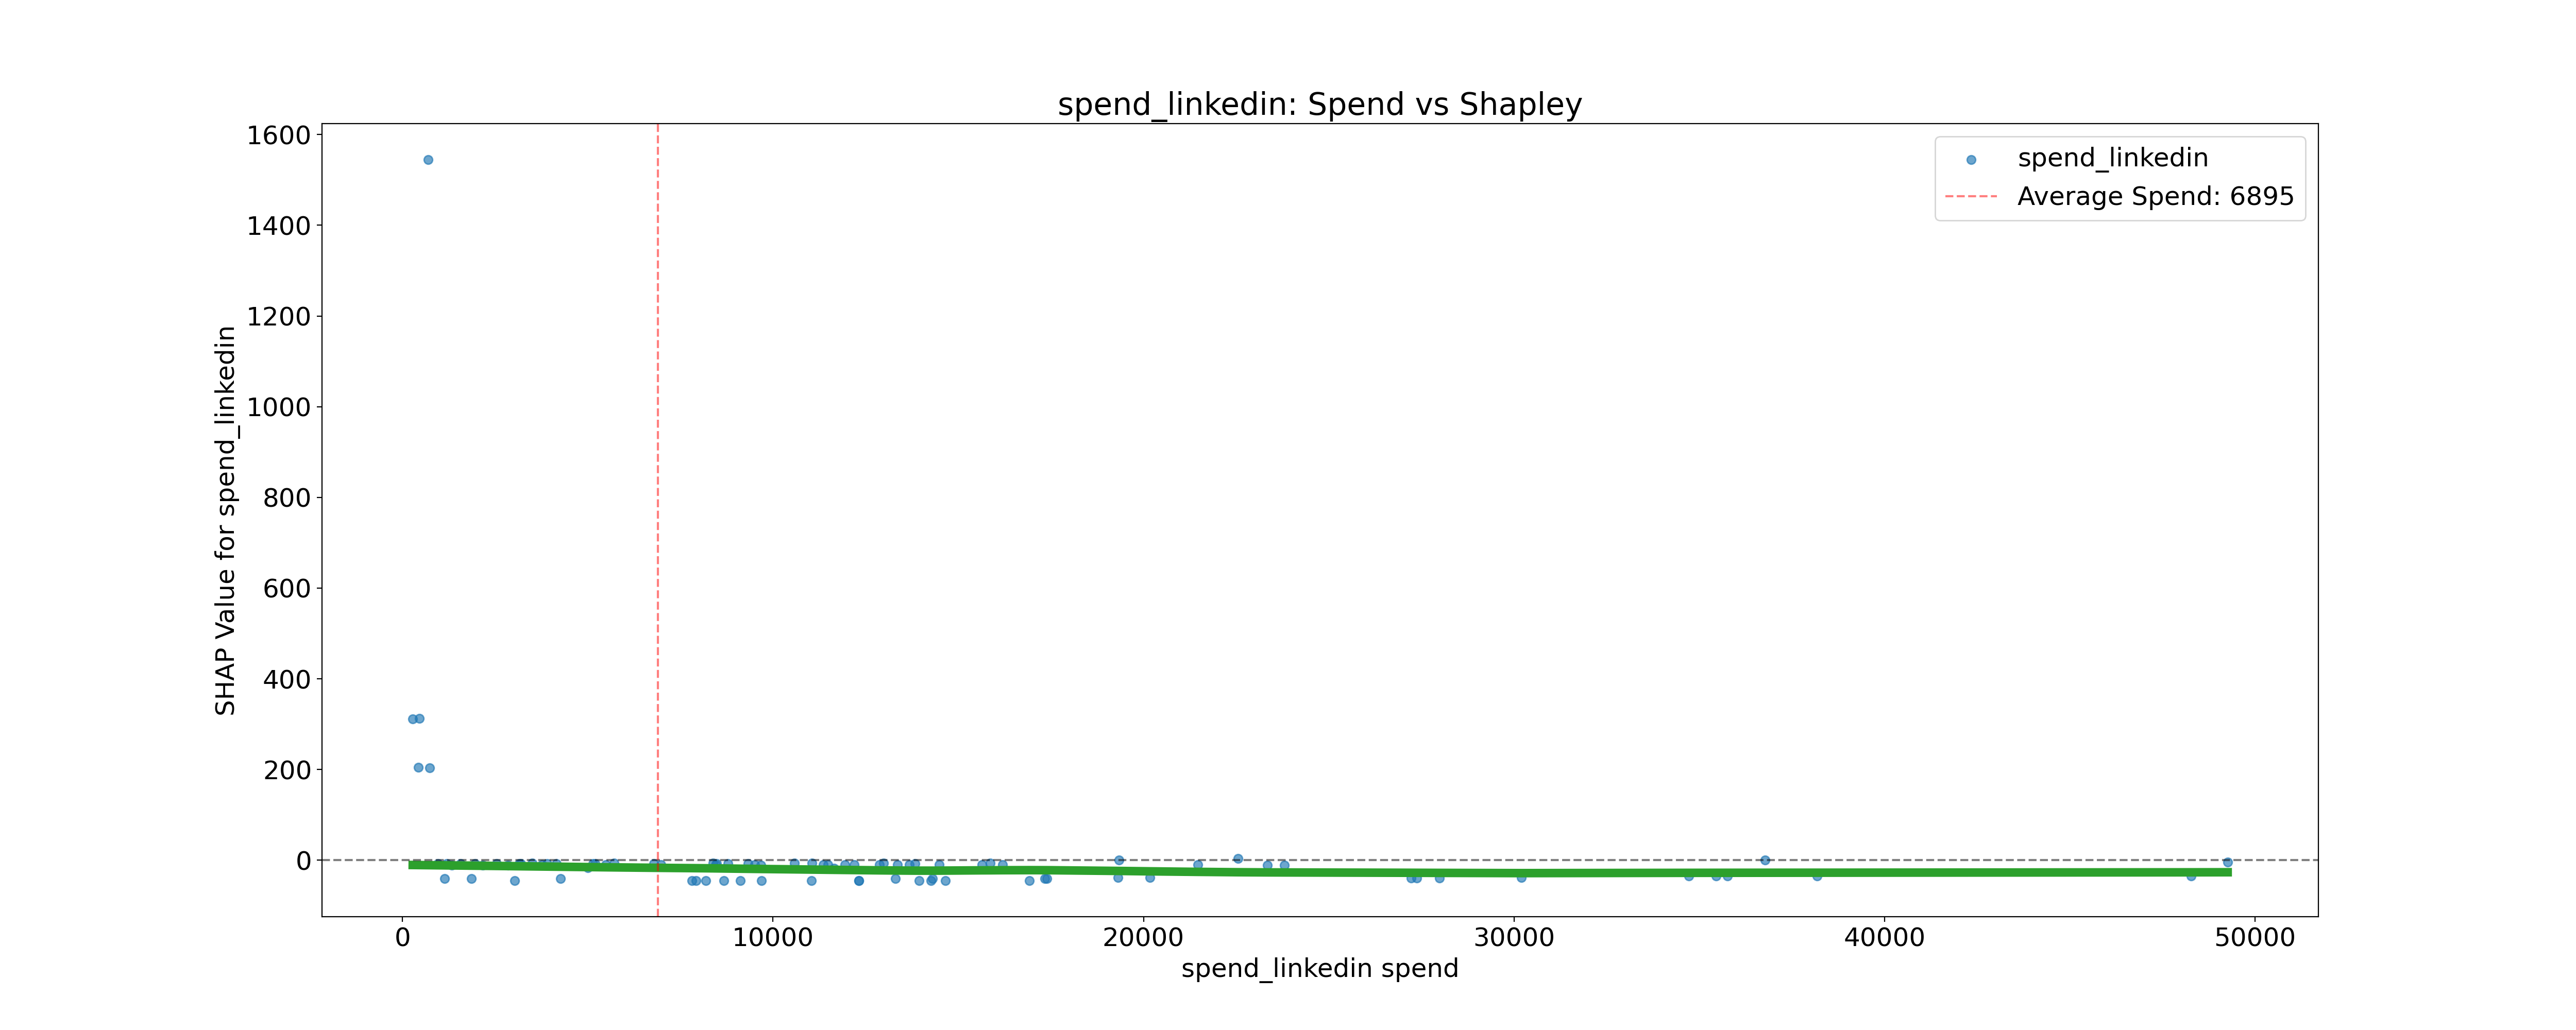

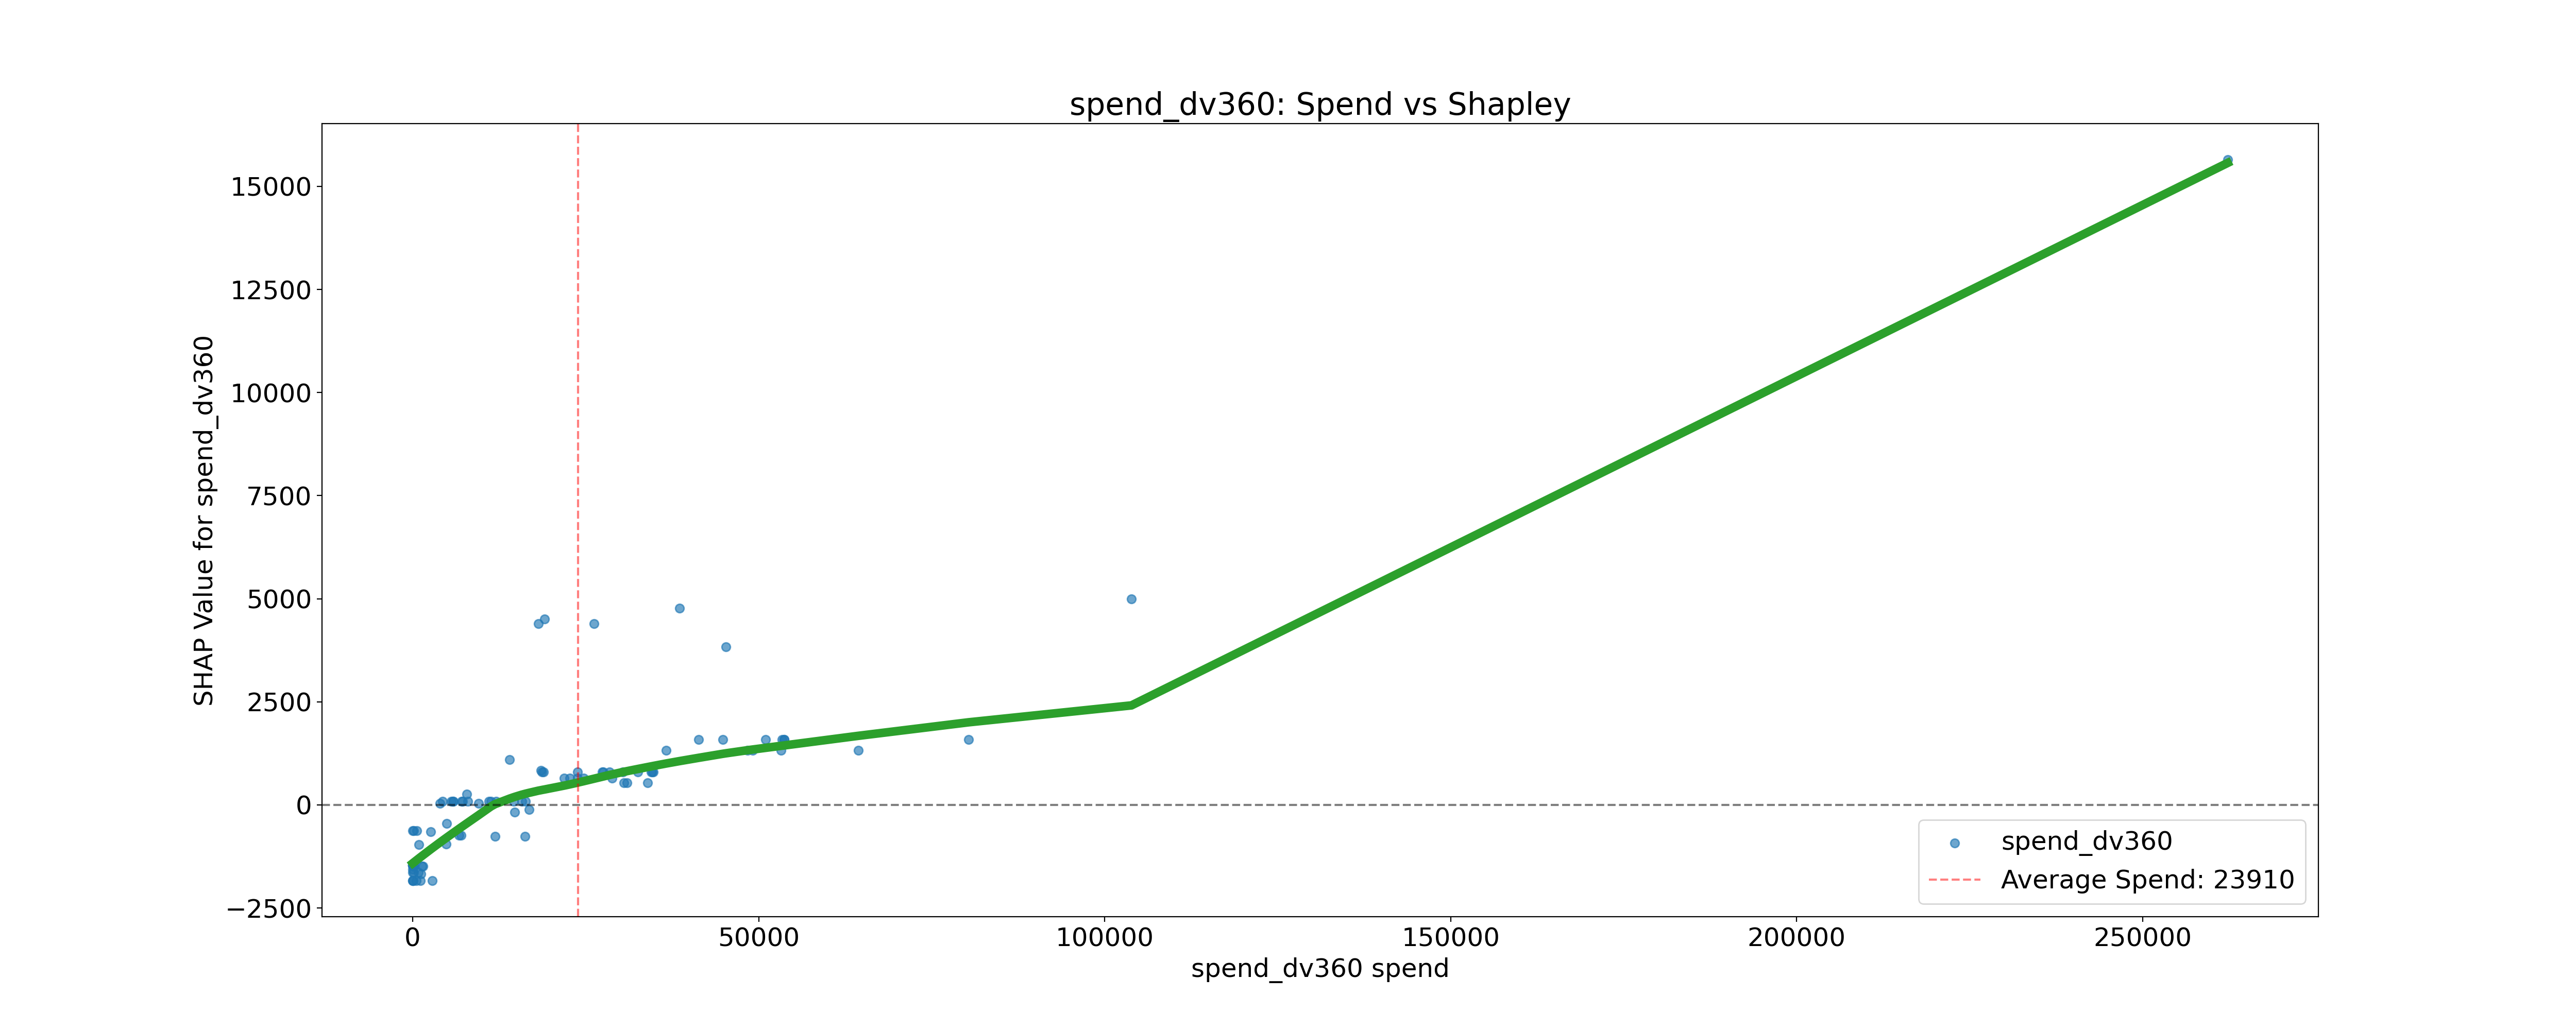

In [143]:
plot_shap_vs_spend(result["df_shap_values"], result["x_input_interval_nontransformed"], result["x_input_interval_transformed"], features, media_channels)


How do we interpret this? 

Let's take spend_dv360: as mentionned before, the SHAP value represents how a given feature contributes to how much more leads are generated than the average prediction across the entire dataset. Here, we can see that the more the spend in dv360 increases, the more the shap value increases (linearly). Therefore, we can say that this media channel is not saturated. 

For instance, for a spend of 100,000 dollars, dv360 will be responsible for the predicted leads value to be approximately 2,000 higher than the average prediction accross all predicted leads values.

## TIME TO MAKE PREDICTIONS

This function below has been explained and constructed in the functions section previously and works in the following way. Below, you are asked to enter values for the variables below, which are the following :

-Start date: start of the stretch of weeks you want to predict leads for. This date should be a SUNDAY. the input should be a string in the following format "yyyy-mm-dd"

-periods: over which period do you want to predict leads? Over how many weeks? this input should be  simple integer value

-spend: input the number of your weekly budget for every channel. This input format shoeld be a float

The function will then take your input into account and create a dataframe which will automatically recreate all the other end of week dates based on the number of weeks you wanted to predict (indicated by the periods variable).

Once this step is done, the function then internally calls another function which takes this newly created dataset as an input and predicts the corresponding leads for every record. This model is trained on the training dataset, and accounts for carry-over effects of spend for every advertising channel!

NB:Here, we did not take into account organic leads data as this would cause target leakage in the case of a predictive task! 

In [144]:
#Define yout inputs

start_date='2023-08-27'
periods=4
spend_linkedin=3434
spend_dv360=1224

In [145]:
#Run the cell to see your predictions!

predict_prophet(start_date=start_date,
            periods=periods,
            spend_linkedin=spend_linkedin,
            spend_dv360=spend_dv360) 

11:41:44 - cmdstanpy - INFO - Chain [1] start processing
11:41:44 - cmdstanpy - INFO - Chain [1] done processing


successfully applied 0.6131622217633432 adstock on spend_linkedin 
successfully applied 0.17255318234981337 adstock on spend_dv360 
Successfully applied adstock to training data
successfully applied 0.6131622217633432 adstock on spend_linkedin 
successfully applied 0.17255318234981337 adstock on spend_dv360 
successfully applied alpha adstock on media spends based on which we want to carry out predictions
predicting 4 weeks worth of Leads based on inputed variables :) 


,ds,predicted_leads
0,2023-08-27,1279.63835
1,2023-09-03,1189.33570
2,2023-09-10,1170.62126
3,2023-09-17,1326.54955
